ANSWER 1

In [12]:
# 1. Load and Prepare Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Load dataset
df = pd.read_csv("C:/Users/lenov/Downloads/breast-cancer.csv")

# Explore dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nClass distribution:")
print(df['diagnosis'].value_counts())

# Preprocessing
X = df.drop(['id', 'diagnosis'], axis=1)
y = df['diagnosis'].map({'M': 1, 'B': 0})  # Convert to binary (1=Malignant, 0=Benign)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


Dataset shape: (569, 32)

First 5 rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  

ANSWER 2

In [13]:
#2. Train SVM with Linear and RBF Kernels

# Linear SVM
linear_svm = SVC(kernel='linear', random_state=42)
linear_svm.fit(X_train_scaled, y_train)

# RBF SVM
rbf_svm = SVC(kernel='rbf', random_state=42)
rbf_svm.fit(X_train_scaled, y_train)

# Evaluate initial performance
print("\nLinear SVM Test Accuracy:", linear_svm.score(X_test_scaled, y_test))
print("RBF SVM Test Accuracy:", rbf_svm.score(X_test_scaled, y_test))



Linear SVM Test Accuracy: 0.9649122807017544
RBF SVM Test Accuracy: 0.9590643274853801


ANSWER 3

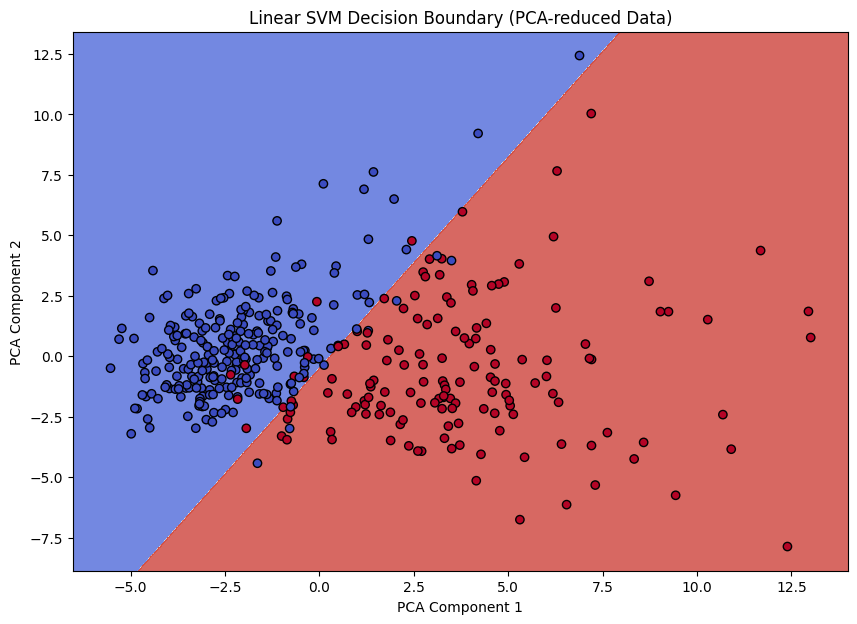

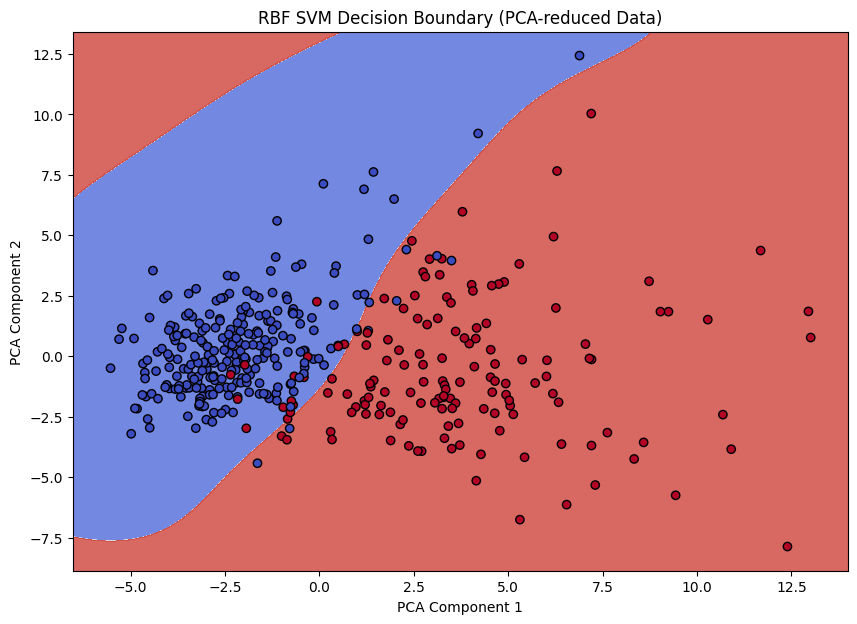

In [14]:
# 3. Visualize Decision Boundary

def plot_decision_boundary(model, X, y, title):
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Predict on mesh points
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Train SVMs on PCA-reduced data
linear_svm_pca = SVC(kernel='linear', random_state=42).fit(X_train_pca, y_train)
rbf_svm_pca = SVC(kernel='rbf', random_state=42).fit(X_train_pca, y_train)

# Plot decision boundaries
plot_decision_boundary(linear_svm_pca, X_train_pca, y_train, 
                      "Linear SVM Decision Boundary (PCA-reduced Data)")
plot_decision_boundary(rbf_svm_pca, X_train_pca, y_train, 
                      "RBF SVM Decision Boundary (PCA-reduced Data)")



ANSWER 4

In [15]:
# Tune Linear SVM (C parameter)
param_grid_linear = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_linear = GridSearchCV(
    SVC(kernel='linear', random_state=42),
    param_grid_linear,
    cv=5,
    scoring='accuracy'
)
grid_linear.fit(X_train_scaled, y_train)

# Tune RBF SVM (C and gamma)
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto']
}
grid_rbf = GridSearchCV(
    SVC(kernel='rbf', random_state=42),
    param_grid_rbf,
    cv=5,
    scoring='accuracy'
)
grid_rbf.fit(X_train_scaled, y_train)

print("\nBest Linear SVM Parameters:", grid_linear.best_params_)
print("Best RBF SVM Parameters:", grid_rbf.best_params_)

# Evaluate tuned models
tuned_linear = grid_linear.best_estimator_
tuned_rbf = grid_rbf.best_estimator_

print("\nTuned Linear SVM Test Accuracy:", tuned_linear.score(X_test_scaled, y_test))
print("Tuned RBF SVM Test Accuracy:", tuned_rbf.score(X_test_scaled, y_test))



Best Linear SVM Parameters: {'C': 0.01}
Best RBF SVM Parameters: {'C': 10, 'gamma': 'scale'}

Tuned Linear SVM Test Accuracy: 0.9532163742690059
Tuned RBF SVM Test Accuracy: 0.9707602339181286


ANSWER 5


Cross-validation Results:
Linear SVM: Mean Accuracy = 0.9698 ± 0.0172
RBF SVM: Mean Accuracy = 0.9722 ± 0.0271


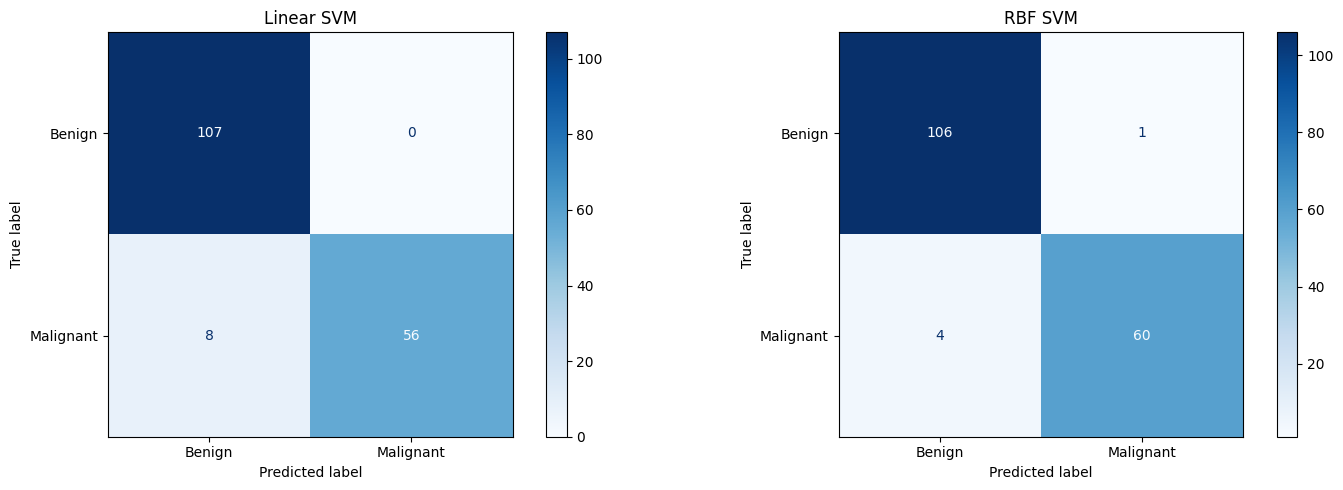

In [16]:
# Evaluate models using 5-fold cross-validation
linear_scores = cross_val_score(
    tuned_linear, X_train_scaled, y_train, cv=5, scoring='accuracy'
)
rbf_scores = cross_val_score(
    tuned_rbf, X_train_scaled, y_train, cv=5, scoring='accuracy'
)

print("\nCross-validation Results:")
print(f"Linear SVM: Mean Accuracy = {linear_scores.mean():.4f} ± {linear_scores.std():.4f}")
print(f"RBF SVM: Mean Accuracy = {rbf_scores.mean():.4f} ± {rbf_scores.std():.4f}")

# Confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
titles = ['Linear SVM', 'RBF SVM']
models = [tuned_linear, tuned_rbf]

for i, model in enumerate(models):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    disp.plot(ax=ax[i], cmap='Blues')
    ax[i].set_title(titles[i])
plt.tight_layout()
plt.show()